## Library

In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from rembg import remove
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Load Data

In [2]:
def load(folders, max_images_per_class=100):
    images = []
    labels = []
    count = {}
    
    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        count[folder_name] = 0
        
        for filename in tqdm(os.listdir(folder_path)):
            if count[folder_name] >= max_images_per_class:
                break
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = remove(img)
                img = cv2.resize(img, (150, 150))
                images.append(img)
                labels.append(folder_name)
                count[folder_name] += 1
    
    return images, labels, count 

folders = ['monarch', 'pipevine_swallow', 'straited_queen']
images, labels, count = load(folders)

100%|██████████| 100/100 [04:52<00:00,  2.92s/it]


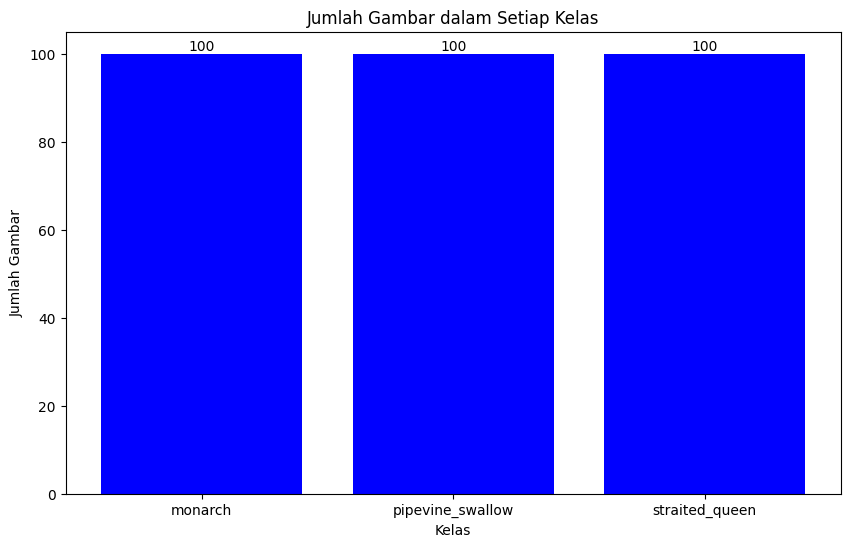

In [3]:
plt.figure(figsize=(10, 6))
bars = plt.bar(count.keys(), count.values(), color='blue')
plt.title('Jumlah Gambar dalam Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height),
             ha='center', va='bottom', fontsize=10)
plt.show()

In [4]:
def plot_tampilan(images, title_prefix):
    plt.figure(figsize=(16, 8))
    for i in range(min(len(images), 6)):
        plt.subplot(1, 6, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{title_prefix} Aug {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Grayscale

In [5]:
def grayscale(img):
    height, width, channels = img.shape
    grayImg = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            gray = int(0.299 * img[i, j, 0] + 0.587 * img[i, j, 1] + 0.114 * img[i, j, 2])
            grayImg[i, j] = gray
            
    return grayImg

def grayscaleData(data):
    gray_data = []
    for i in tqdm(range(len(data))):
        gray_data.append(grayscale(data[i]))
    return gray_data

grayData = grayscaleData(images)

100%|██████████| 300/300 [00:45<00:00,  6.59it/s]


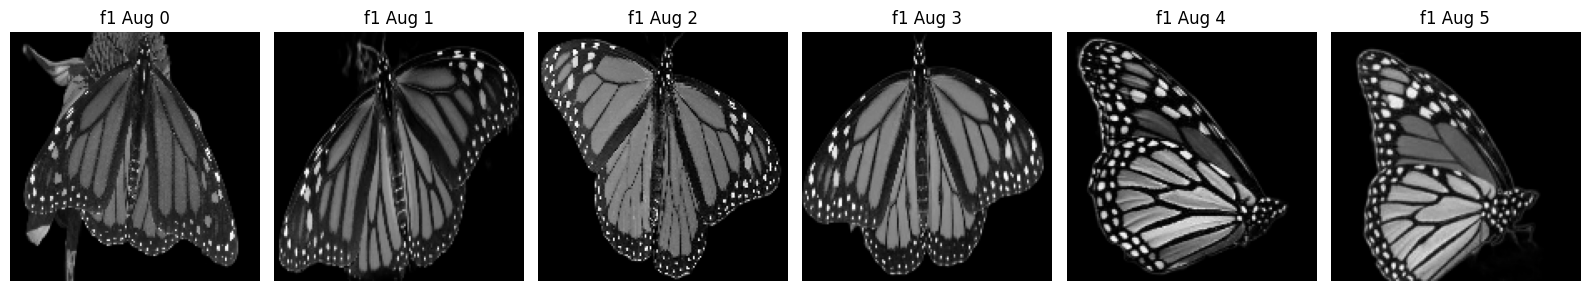

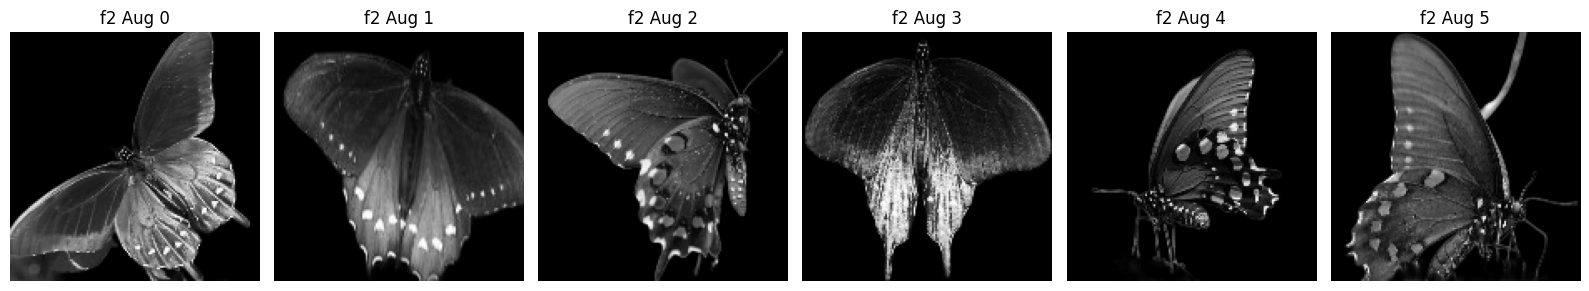

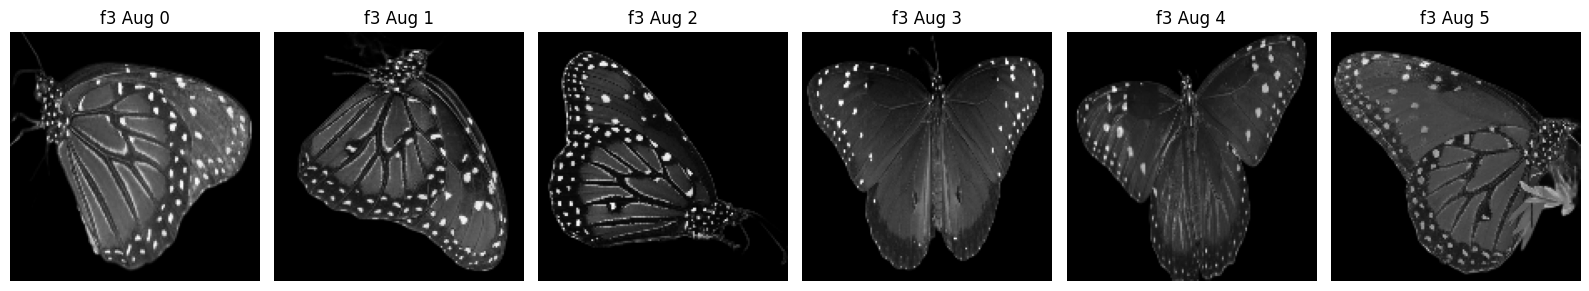

In [6]:
plot_tampilan(grayData[:6], "f1")
plot_tampilan(grayData[100:106], "f2")
plot_tampilan(grayData[200:206], "f3")

## Normalisasi

In [7]:
def normalize_image(images):
    normalized_images = []
    for img in images:
        min_val = np.min(img)
        max_val = np.max(img)
        if min_val < 0 or max_val > 255:
            img = np.clip(img, 0, 255) 
        normalized_img = ((img - np.min(img)) / (np.max(img) - np.min(img))) * 255
        normalized_images.append(normalized_img.astype(np.uint8))
    return normalized_images


In [8]:
norm_f1 = normalize_image([img for img, label in tqdm(zip(grayData, labels)) if label == 'monarch'])
norm_f2 = normalize_image([img for img, label in tqdm(zip(grayData, labels)) if label == 'pipevine_swallow'])
norm_f3 = normalize_image([img for img, label in tqdm(zip(grayData, labels)) if label == 'straited_queen'])

300it [00:00, ?it/s]
300it [00:00, ?it/s]
300it [00:00, ?it/s]


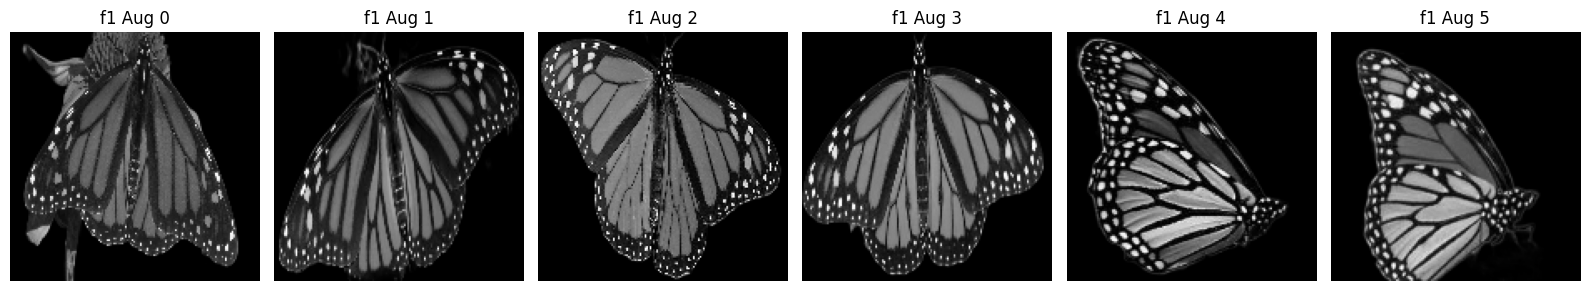

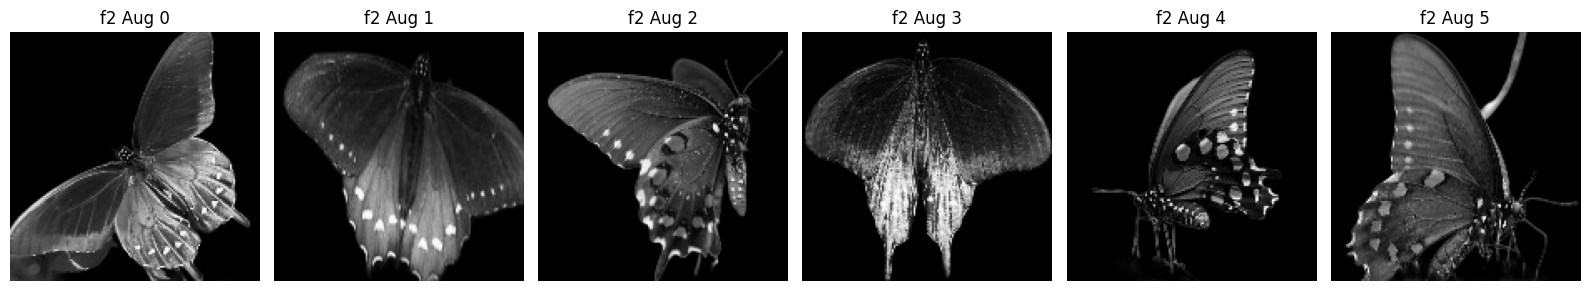

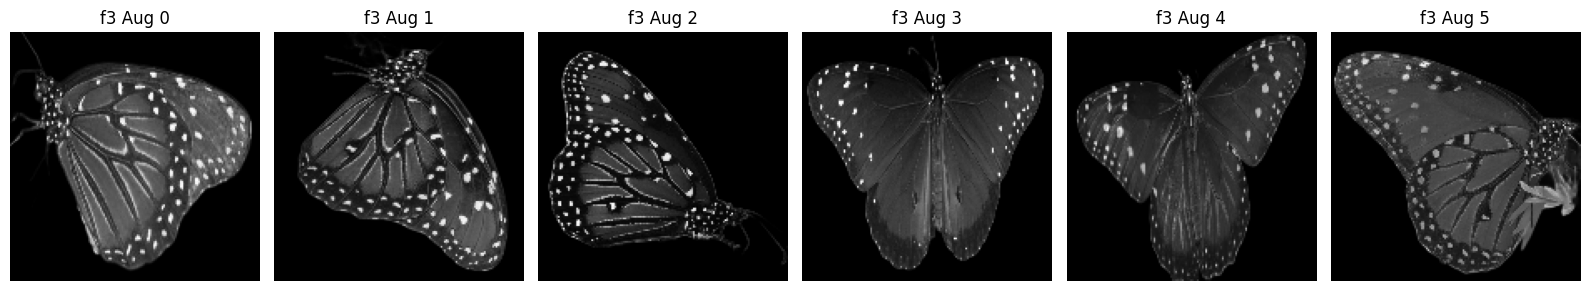

In [9]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## Ekualisasi Histogram

In [10]:
def histogram_equalization(img):
    histogram = np.zeros(256, dtype=int)
    for pixel_value in np.nditer(img):
        histogram[pixel_value] += 1
    
    cdf = np.zeros(256, dtype=int)
    cdf[0] = histogram[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + histogram[i]
    cdf_normalized = ((cdf - cdf.min()) * 255) // (cdf.max() - cdf.min())
    
    equalized_img = cdf_normalized[img]
    return equalized_img

In [12]:
norm_f1 = [histogram_equalization(img) for img in tqdm(norm_f1)]
norm_f2 = [histogram_equalization(img) for img in tqdm(norm_f2)]
norm_f3 = [histogram_equalization(img) for img in tqdm(norm_f3)]

100%|██████████| 100/100 [00:01<00:00, 88.00it/s]


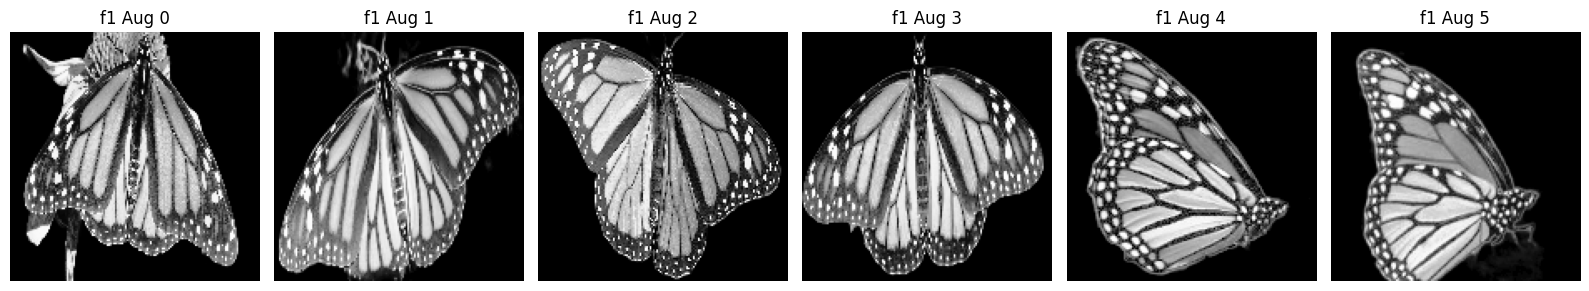

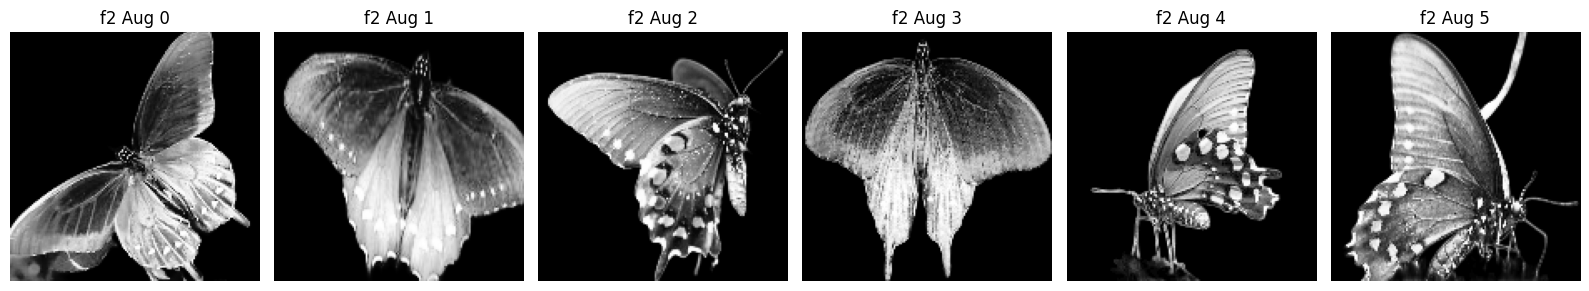

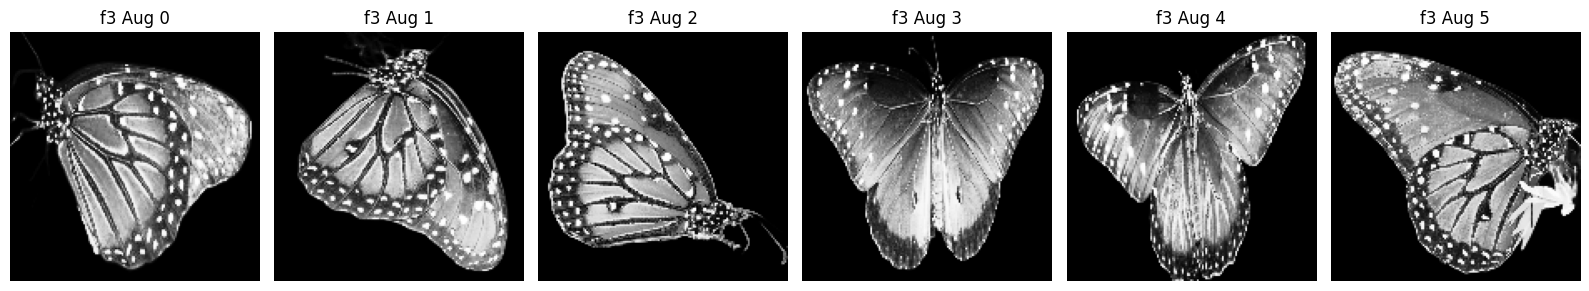

In [13]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## Median Filter

In [40]:
def median(img):
    hImg, wImg = img.shape
    kernel = np.zeros((3,3))
    padding_height = kernel.shape[0]//2
    padding_width = kernel.shape[1]//2
    padded_img = np.pad(img, ((padding_height, padding_height), (padding_width, padding_width)), mode='constant')

    result = np.zeros((hImg, wImg), dtype=np.uint8)

    for i in range(hImg):
        for j in range(wImg):
            sub_img = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            sub_image = np.ravel(sub_img)
            n = len(sub_image)
            for p in range(n - 1):
                min_indeks = p
                for q in range(p + 1, n):
                    if sub_image[q] < sub_image[min_indeks]:
                        min_indeks = q
                sub_image_p = sub_image[p]
                sub_image[p] = sub_image[min_indeks]
                sub_image[min_indeks] = sub_image_p
            
            median_index = kernel.shape[0] * kernel.shape[1]//2
            result[i, j] = sub_image[median_index]
    return result

In [41]:
norm_f1 = [median(img) for img in tqdm(norm_f1)]
norm_f2 = [median(img) for img in tqdm(norm_f2)]
norm_f3 = [median(img) for img in tqdm(norm_f3)]

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


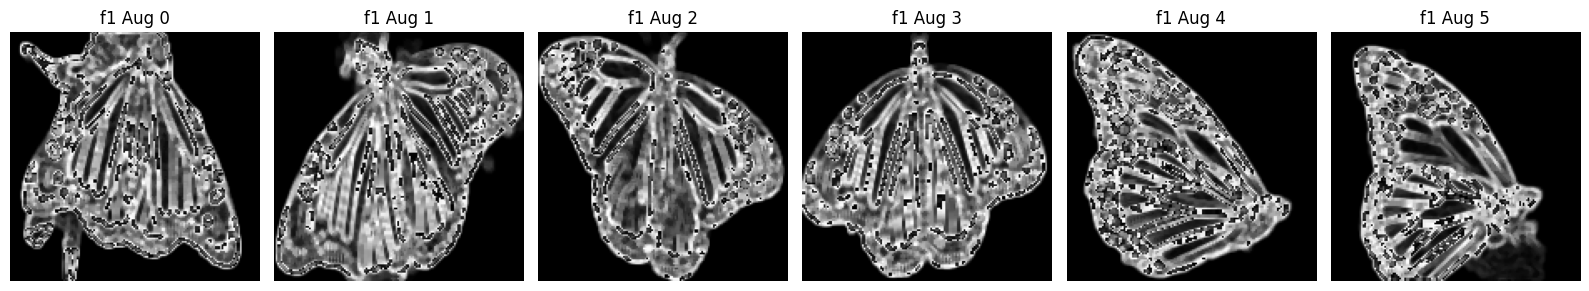

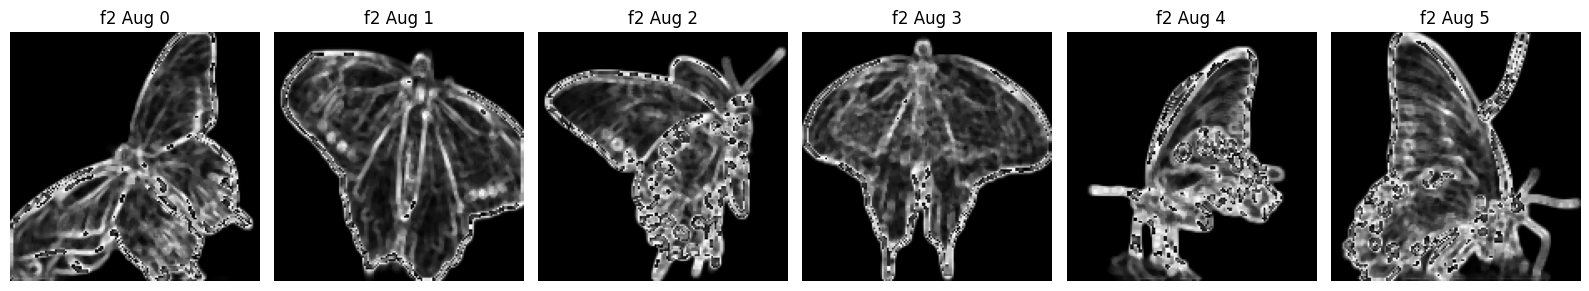

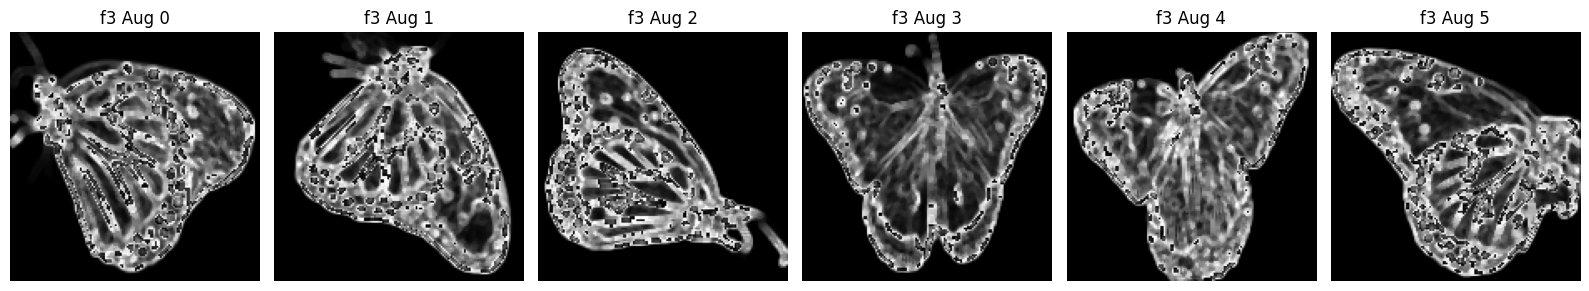

In [42]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## Prewitt

In [43]:
def konvolusi_gradient(img, kernel):
    hImg, wImg = img.shape
    hKernel, wKernel = kernel.shape

    pad_height = hKernel // 2
    pad_width = wKernel // 2

    pad_img = np.pad(img.astype(int), pad_width=((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    result = np.zeros_like(img, dtype=int)
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            sum = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    sum += pad_img[i+k, j+l] * kernel[k, l]
            result[i, j] = sum
    return result

In [44]:
def prewitt(img):
    gx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    gy = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

    x = konvolusi_gradient(img, gx)
    y = konvolusi_gradient(img, gy)

    magnitude = abs(x) + abs(y)

    return magnitude

In [45]:
norm_f1 = [prewitt(img) for img in tqdm(norm_f1)]
norm_f2 = [prewitt(img) for img in tqdm(norm_f2)]
norm_f3 = [prewitt(img) for img in tqdm(norm_f3)]

100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


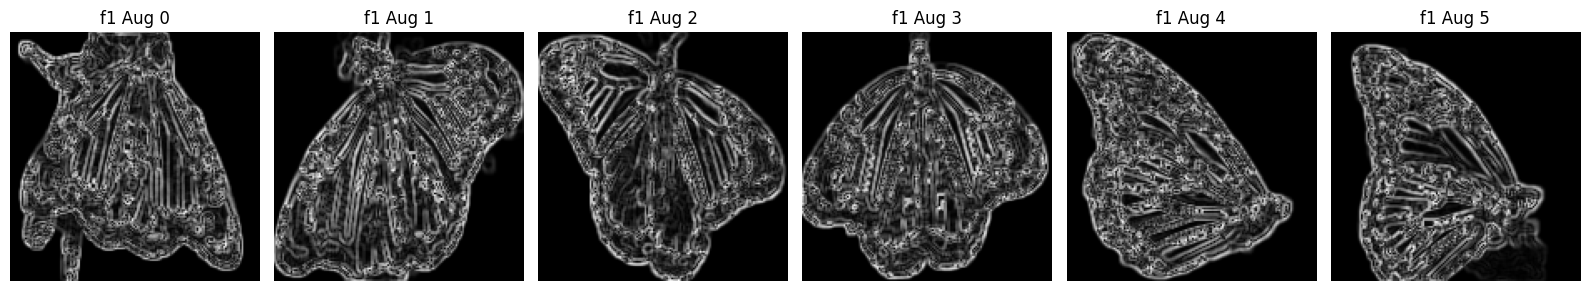

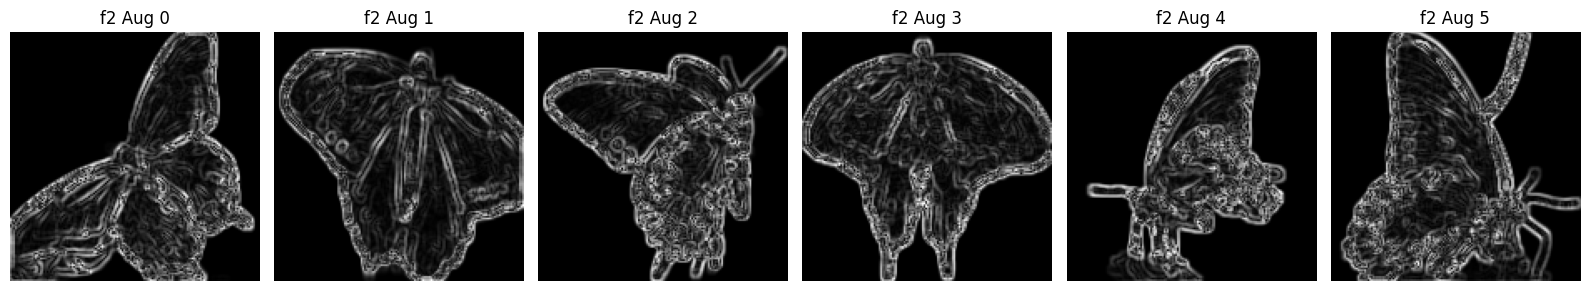

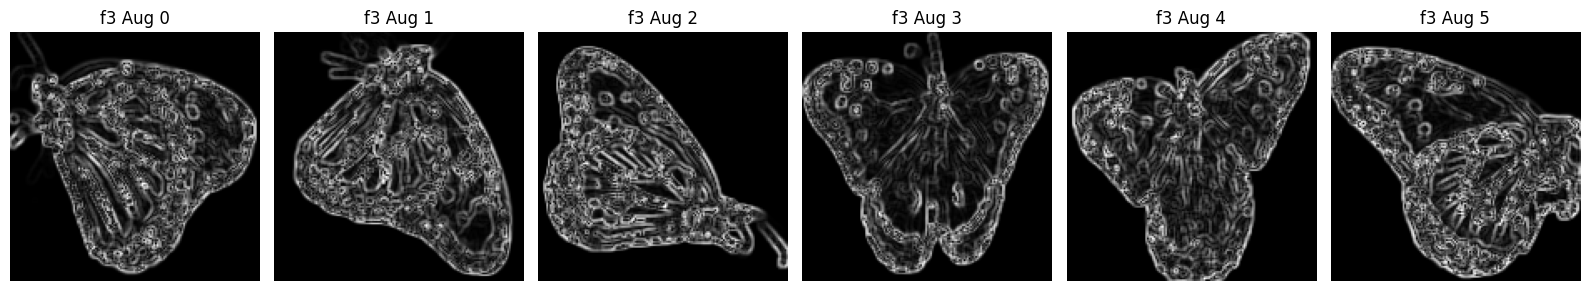

In [46]:
plot_tampilan(norm_f1[:6], "f1")
plot_tampilan(norm_f2[:6], "f2")
plot_tampilan(norm_f3[:6], "f3")

## GLCM

In [27]:
dict_labels = {
    'monarch': 0,
    'pipevine_swallow': 1,
    'straited_queen': 2,
}

In [28]:
def contrast(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i, j] * pow(i - j, 2)
    return hasil

def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i, j] * abs(i - j)
    return hasil

def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (data[i, j] / (1 + pow(i - j, 2)))
    return hasil

def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil

def correlation(data):
    mean_x = 0
    mean_y = 0
    std_x = 0
    std_y = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean_x += i * data[i][j]
            mean_y += j * data[i][j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std_x += (i - mean_x) ** 2 * data[i][j]
            std_y += (j - mean_y) ** 2 * data[i][j]
    std_x = math.sqrt(std_x)
    std_y = math.sqrt(std_y)
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean_x) * (j - mean_y) * data[i][j]
    hasil /= std_x * std_y
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy

def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [29]:
def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    for i, image in enumerate(tqdm(images)):
        image = image.astype(int)
        glcm = graycomatrix(image, distances, angles, levels, symmetric, normed)
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                glcm_matrix = glcm[:, :, 0, int(angle * 4 / np.pi)]
                if feature == 'contrast':
                    feat_a = contrast(glcm_matrix)
                elif feature == 'dissimilarity':
                    feat_a = dissimilarity(glcm_matrix)
                elif feature == 'homogeneity':
                    feat_a = homogeneity(glcm_matrix)
                elif feature == 'energy':
                    feat_a = energy(glcm_matrix)
                elif feature == 'correlation':
                    feat_a = correlation(glcm_matrix)
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        for angle, angle_label in zip(angles, angle_labels):
            glcm_matrix = glcm[:, :, 0, int(angle * 4 / np.pi)]
            asm_value = asm(glcm_matrix)
            entropy_value = entropy(glcm_matrix)
            df_data.loc[i, f'asm_{angle_label}'] = asm_value
            df_data.loc[i, f'entropy_{angle_label}'] = entropy_value
        df_data.loc[i, 'label'] = dict_labels[labels[i]]
    return df_data

In [47]:
norm_images = norm_f1 + norm_f2 + norm_f3
norm_images = normalize_image(norm_images)
norm_labels = ['monarch'] * len(norm_f1) + ['pipevine_swallow'] * len(norm_f2) + ['straited_queen'] * len(norm_f3)

df_glcm = extract_glcm_features(norm_images, norm_labels)

100%|██████████| 300/300 [10:21<00:00,  2.07s/it]


## Seleksi Fitur

In [48]:
correlations = df_glcm.corr()['label'].abs().sort_values(ascending=False)
top_features = correlations.index[1:26]  
print("Top features based on correlation with the label:", top_features)

Top features based on correlation with the label: Index(['entropy_90', 'correlation_90', 'entropy_45', 'entropy_135',
       'entropy_0', 'correlation_135', 'correlation_45', 'correlation_0',
       'homogeneity_90', 'homogeneity_45', 'homogeneity_135', 'homogeneity_0',
       'dissimilarity_135', 'dissimilarity_45', 'dissimilarity_0', 'asm_90',
       'energy_90', 'dissimilarity_90', 'energy_45', 'asm_45', 'energy_135',
       'asm_135', 'asm_0', 'energy_0', 'contrast_135'],
      dtype='object')


In [49]:
x, y = df_glcm[top_features], df_glcm['label']

In [50]:
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## KNN, SVM, RFC

In [52]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
knn_pred = knn_model.predict(x_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

svm_model = SVC()
svm_model.fit(x_train, y_train)
svm_pred = svm_model.predict(x_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [53]:
model_dict = {
    'KNN': knn_model,
    'SVM': svm_model,
    'RF': rf_model
}

df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())

In [54]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')

In [55]:
print(df_eval)

     Accuracy Precision    Recall  F1 Score
KNN  0.616667  0.620586  0.616667  0.605093
SVM  0.633333  0.631014  0.633333  0.631876
RF       0.65  0.657778      0.65   0.64963


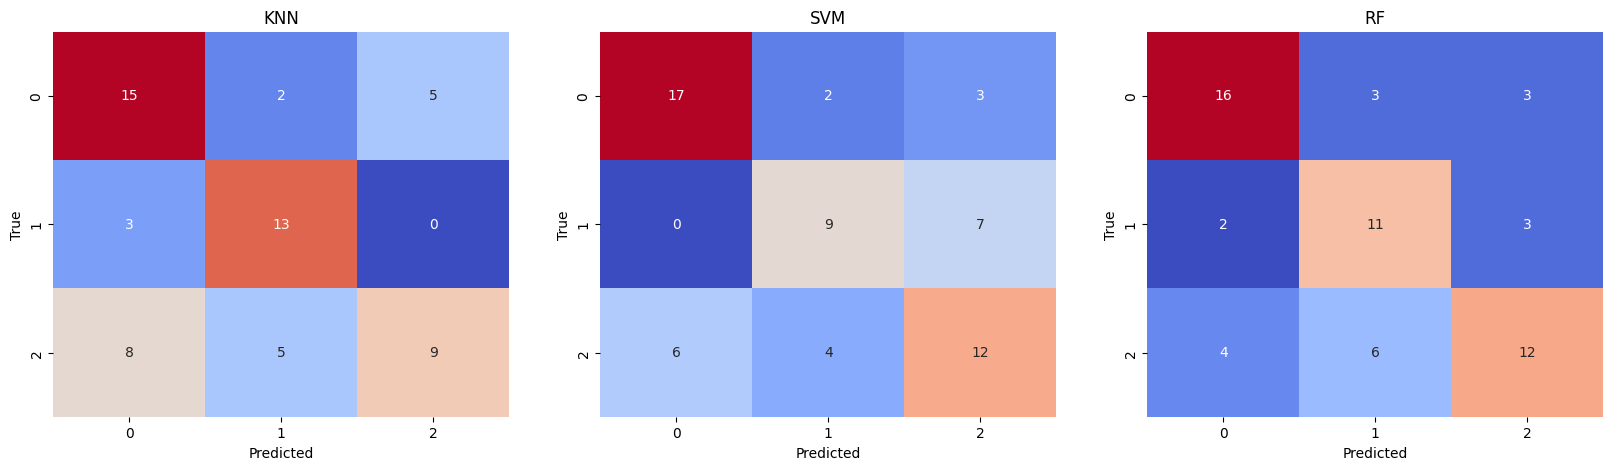

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, model_name in enumerate(model_dict.keys()):
    y_pred = model_dict[model_name].predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(model_name)
plt.show()